In [ ]:
import torch
import torchvision
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.ops import box_iou
import time
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import numpy as np

class RetinaNetDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        
        # Get image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(list(self.images_dir.glob(ext)))
        
        print(f"RetinaNet Dataset: {len(self.image_files)} images in {images_dir}")
        
        # Fixed transform
        self.transform = T.Compose([T.ToTensor()])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get labels
        label_name = img_path.stem + '.txt'
        label_path = self.labels_dir / label_name
        
        boxes = []
        labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            # YOLO format: class_id x_center y_center width height (normalized)
                            # RetinaNet: NO background class, so use original class_id
                            class_id = int(parts[0])  # 0=carretera, 1=rio
                            x_center, y_center, width, height = map(float, parts[1:5])
                            
                            # Convert to absolute coordinates
                            img_width, img_height = image.size
                            x_center *= img_width
                            y_center *= img_height
                            width *= img_width
                            height *= img_height
                            
                            # Convert to [x1, y1, x2, y2]
                            x1 = max(0, x_center - width/2)
                            y1 = max(0, y_center - height/2)
                            x2 = min(img_width, x_center + width/2)
                            y2 = min(img_height, y_center + height/2)
                            
                            # Validate box
                            if x2 > x1 + 1 and y2 > y1 + 1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(class_id)
        
        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 10, 10]]  # Small dummy box
            labels = [0]  # Default to carretera
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
        }
        
        # Apply transform
        image = self.transform(image)
        
        return image, target

def collate_fn(batch):
    """Collate function for RetinaNet dataloaders"""
    return tuple(zip(*batch))

def create_retinanet_dataloaders():
    """Create RetinaNet dataloaders"""
    root = Path('data/ImagenesFiltradas')
    
    # Check paths
    train_images = root / 'train' / 'images'
    train_labels = root / 'train' / 'labels'
    val_images = root / 'val' / 'images'
    val_labels = root / 'val' / 'labels'
    
    print("Checking RetinaNet paths:")
    for path in [train_images, train_labels, val_images, val_labels]:
        status = "✓" if path.exists() else "✗"
        print(f"  {status} {path}")
    
    # Create datasets
    train_dataset = RetinaNetDataset(train_images, train_labels)
    val_dataset = RetinaNetDataset(val_images, val_labels)
    
    # Create dataloaders (using num_workers=0 to avoid multiprocessing issues)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16,  # Increased batch size to match YOLO
        shuffle=True, 
        collate_fn=collate_fn, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=torch.cuda.is_available()
    )
    
    print(f"RetinaNet DataLoaders created:")
    print(f"  Train: {len(train_dataset)} images, {len(train_loader)} batches")
    print(f"  Val: {len(val_dataset)} images, {len(val_loader)} batches")
    
    return train_loader, val_loader

def setup_retinanet():
    """Setup RetinaNet without freezing - full training"""
    # Load pretrained model
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    
    # Replace classification head for 2 classes (carretera, rio)
    print("Replacing classification head for 2 classes...")
    num_classes = 2
    num_anchors = model.head.classification_head.num_anchors
    
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes
    )
    
    # Count parameters - all trainable now
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"RetinaNet parameters (all trainable):")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,} ({trainable_params/total_params:.1%})")
    
    return model

def calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5, device='cpu'):
    """Calculate Average Precision for a single class"""
    if len(pred_boxes) == 0:
        return 0.0
    if len(gt_boxes) == 0:
        return 0.0
    
    # Ensure all tensors are on the same device
    pred_boxes = pred_boxes.to(device)
    pred_scores = pred_scores.to(device)
    pred_labels = pred_labels.to(device)
    gt_boxes = gt_boxes.to(device)
    gt_labels = gt_labels.to(device)
    
    # Sort predictions by score (descending)
    sort_idx = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sort_idx]
    pred_scores = pred_scores[sort_idx]
    pred_labels = pred_labels[sort_idx]
    
    # Calculate IoU between all pred and gt boxes
    ious = box_iou(pred_boxes, gt_boxes)
    
    # For each prediction, find best matching ground truth
    tp = torch.zeros(len(pred_boxes), device=device)
    gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
    
    for i, (pred_box, pred_score, pred_label) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
        # Find best IoU with ground truth of same class
        best_iou = 0
        best_gt_idx = -1
        
        for j, gt_label in enumerate(gt_labels):
            if pred_label == gt_label and not gt_matched[j]:
                iou = ious[i, j]
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
        
        # Check if it's a true positive
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
    
    # Calculate precision and recall
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(1 - tp, dim=0)
    
    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    # Calculate AP using 11-point interpolation
    recall_levels = torch.linspace(0, 1, 11, device=device)
    ap = 0
    for r in recall_levels:
        precisions_above_r = precision[recall >= r]
        if len(precisions_above_r) > 0:
            ap += torch.max(precisions_above_r)
    ap /= 11
    
    return ap.item()

def calculate_map(predictions, targets, num_classes=2, iou_thresholds=None, device='cpu'):
    """Calculate mAP@0.5 and mAP@0.5:0.95"""
    if iou_thresholds is None:
        iou_thresholds = [0.5]  # For mAP@0.5
    
    aps_per_class = []
    
    for class_id in range(num_classes):
        class_aps = []
        
        for iou_thresh in iou_thresholds:
            all_pred_boxes = []
            all_pred_scores = []
            all_pred_labels = []
            all_gt_boxes = []
            all_gt_labels = []
            
            # Collect all predictions and targets for this class
            for pred, target in zip(predictions, targets):
                # Filter predictions for this class
                class_mask = pred['labels'] == class_id
                if class_mask.sum() > 0:
                    all_pred_boxes.append(pred['boxes'][class_mask].cpu())
                    all_pred_scores.append(pred['scores'][class_mask].cpu())
                    all_pred_labels.append(pred['labels'][class_mask].cpu())
                
                # Filter targets for this class
                gt_class_mask = target['labels'] == class_id
                if gt_class_mask.sum() > 0:
                    all_gt_boxes.append(target['boxes'][gt_class_mask].cpu())
                    all_gt_labels.append(target['labels'][gt_class_mask].cpu())
            
            if len(all_pred_boxes) > 0 and len(all_gt_boxes) > 0:
                # Concatenate all boxes/scores/labels
                pred_boxes = torch.cat(all_pred_boxes, dim=0)
                pred_scores = torch.cat(all_pred_scores, dim=0)
                pred_labels = torch.cat(all_pred_labels, dim=0)
                gt_boxes = torch.cat(all_gt_boxes, dim=0)
                gt_labels = torch.cat(all_gt_labels, dim=0)
                
                ap = calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_thresh, device)
                class_aps.append(ap)
            else:
                class_aps.append(0.0)
        
        aps_per_class.append(np.mean(class_aps))
    
    return np.mean(aps_per_class)

def train_retinanet():
    """Train RetinaNet with full training (no freezing)"""
    print("=== RETINANET FULL TRAINING ===")
    
    # Create dataloaders
    train_loader, val_loader = create_retinanet_dataloaders()
    
    # Setup model
    model = setup_retinanet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Training on: {device}")
    print("Class mapping: 0=carretera, 1=rio")
    
    # Optimizer for all parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    # Training settings
    epochs = 50  # Match YOLO epochs
    best_map = 0.0
    patience_counter = 0
    patience = 8  # Match YOLO patience
    
    print(f"Training for {epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            try:
                # Move to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Check for invalid losses
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"  Skipping batch {batch_idx}: invalid loss")
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += losses.item()
                num_batches += 1
                
                if batch_idx % 10 == 0:
                    print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {losses.item():.4f}')
                    
            except Exception as e:
                print(f"  Skipping batch {batch_idx}: {e}")
                continue
        
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        
        # Validation and mAP calculation
        if epoch % 5 == 0 or epoch == epochs - 1:  # Calculate mAP every 5 epochs
            map50, map50_95 = evaluate_retinanet_map(model, val_loader, device)
            
            print(f'Epoch {epoch+1} Results:')
            print(f'  Train Loss: {avg_loss:.4f}')
            print(f'  mAP@0.5: {map50:.4f} ({map50*100:.2f}%)')
            print(f'  mAP@0.5:0.95: {map50_95:.4f} ({map50_95*100:.2f}%)')
            
            # Early stopping check
            if map50 > best_map:
                best_map = map50
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), 'retinanet_best.pth')
                print(f'  New best mAP@0.5: {best_map:.4f} - Model saved!')
            else:
                patience_counter += 1
                print(f'  No improvement. Patience: {patience_counter}/{patience}')
                
                if patience_counter >= patience:
                    print(f'  Early stopping triggered after {epoch+1} epochs')
                    break
        else:
            print(f'Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}')
        
        scheduler.step()
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nRetinaNet training completed in {training_time:.2f} seconds")
    print(f"Time per epoch: {training_time/(epoch+1):.1f} seconds")
    print(f"Best mAP@0.5: {best_map:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), 'retinanet_final.pth')
    print(f"Final model saved: retinanet_final.pth")
    
    return model

def evaluate_retinanet_map(model, val_loader, device):
    """Evaluate RetinaNet and calculate mAP@0.5 and mAP@0.5:0.95"""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            # Filter predictions by confidence threshold
            filtered_predictions = []
            for pred in predictions:
                scores = pred['scores']
                mask = scores > 0.05  # Low threshold to capture all potential detections
                
                filtered_pred = {
                    'boxes': pred['boxes'][mask],
                    'scores': pred['scores'][mask],
                    'labels': pred['labels'][mask]
                }
                filtered_predictions.append(filtered_pred)
            
            all_predictions.extend(filtered_predictions)
            all_targets.extend(targets)
    
    # Calculate mAP@0.5 (move computations to CPU for stability)
    map50 = calculate_map(all_predictions, all_targets, num_classes=2, iou_thresholds=[0.5], device='cpu')
    
    # Calculate mAP@0.5:0.95
    iou_thresholds = np.arange(0.5, 1.0, 0.05)  # [0.5, 0.55, 0.6, ..., 0.95]
    map50_95 = calculate_map(all_predictions, all_targets, num_classes=2, iou_thresholds=iou_thresholds, device='cpu')
    
    return map50, map50_95

def evaluate_retinanet():
    """Final evaluation of RetinaNet with detailed metrics"""
    print("=== RETINANET FINAL EVALUATION ===")
    
    # Load model
    model = setup_retinanet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if os.path.exists('retinanet_best.pth'):
        model.load_state_dict(torch.load('retinanet_best.pth', map_location=device))
        print("Best RetinaNet model loaded successfully")
    elif os.path.exists('retinanet_final.pth'):
        model.load_state_dict(torch.load('retinanet_final.pth', map_location=device))
        print("Final RetinaNet model loaded successfully")
    else:
        print("No RetinaNet model file found")
        return
    
    model.to(device)
    
    # Get validation loader
    _, val_loader = create_retinanet_dataloaders()
    
    # Calculate mAP metrics
    map50, map50_95 = evaluate_retinanet_map(model, val_loader, device)
    
    class_names = {0: 'carretera', 1: 'rio'}
    
    print(f"\nFinal RetinaNet Results:")
    print(f"  mAP@0.5: {map50:.4f} ({map50*100:.2f}%)")
    print(f"  mAP@0.5:0.95: {map50_95:.4f} ({map50_95*100:.2f}%)")
    
    return {
        'map50': map50,
        'map50_95': map50_95
    }

def run_retinanet_pipeline():
    """Complete RetinaNet pipeline similar to YOLO"""
    print("RETINANET TRAINING PIPELINE")
    print("="*50)
    
    start = time.time()
    
    # Train
    model = train_retinanet()
    
    end = time.time()
    print(f"Execution time: {end-start:.2f} seconds")
    
    if model is not None:
        print("\n" + "="*50)
        # Final evaluation
        results = evaluate_retinanet()
        print(f"\nRetinaNet pipeline completed!")
        return results
    else:
        print("RetinaNet training failed")
        return None

if __name__ == "__main__":
    results = run_retinanet_pipeline()

RETINANET TRAINING PIPELINE
=== RETINANET FULL TRAINING ===
Checking RetinaNet paths:
  ✓ data\ImagenesFiltradas\train\images
  ✓ data\ImagenesFiltradas\train\labels
  ✓ data\ImagenesFiltradas\val\images
  ✓ data\ImagenesFiltradas\val\labels
RetinaNet Dataset: 610 images in data\ImagenesFiltradas\train\images
RetinaNet Dataset: 74 images in data\ImagenesFiltradas\val\images
RetinaNet DataLoaders created:
  Train: 610 images, 39 batches
  Val: 74 images, 5 batches
Replacing classification head for 2 classes...
RetinaNet parameters (all trainable):
  Total: 32,168,694
  Trainable: 31,946,294 (99.3%)
Training on: cuda
Class mapping: 0=carretera, 1=rio
Training for 50 epochs...

Epoch 1/50
------------------------------
  Batch 0/39, Loss: 1.8130
  Batch 10/39, Loss: 1.6665
  Batch 20/39, Loss: 1.5748
  Batch 30/39, Loss: 1.6752
Epoch 1 Results:
  Train Loss: 1.6807
  mAP@0.5: 0.0000 (0.00%)
  mAP@0.5:0.95: 0.0000 (0.00%)
  No improvement. Patience: 1/8

Epoch 2/50
------------------------

matplotlib is available
RETINANET INFERENCE TESTING
1. Testing on validation images with visualizations:
Testing on validation images...
Testing RetinaNet on images from: data\ImagenesFiltradas\val\images
Found 90 images
Loading trained RetinaNet from: retinanet_best.pth


C:\Users\ca.daza10\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ca.daza10\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully on cuda

--- Image 1/10: video_11min_641.jpg ---
Size: (1920, 1080), Detections: 3
Drawing 3 detections:
  1. carretera: 0.347 at [117, 165, 880, 421]
  2. rio: 0.325 at [117, 165, 880, 421]
  3. carretera: 0.308 at [702, 437, 1810, 745]

--- Image 2/10: video_11min_641_predicted.jpg ---
Size: (1920, 1080), Detections: 20
Drawing 20 detections:
  1. carretera: 0.543 at [109, 158, 882, 428]
  2. rio: 0.512 at [109, 158, 882, 428]
  3. carretera: 0.441 at [338, 106, 960, 570]
  4. carretera: 0.441 at [605, 157, 1027, 658]
  5. carretera: 0.437 at [474, 255, 1209, 630]
  6. rio: 0.418 at [474, 255, 1209, 630]
  7. carretera: 0.405 at [644, 439, 1667, 741]
  8. carretera: 0.392 at [733, 319, 896, 677]
  9. rio: 0.392 at [644, 439, 1667, 741]
  10. carretera: 0.389 at [688, 302, 1298, 747]
  11. carretera: 0.377 at [171, 46, 769, 555]
  12. rio: 0.375 at [244, 165, 1052, 539]
  13. carretera: 0.368 at [700, 363, 1088, 586]
  14. rio: 0.345 at [700, 363, 1088, 586]


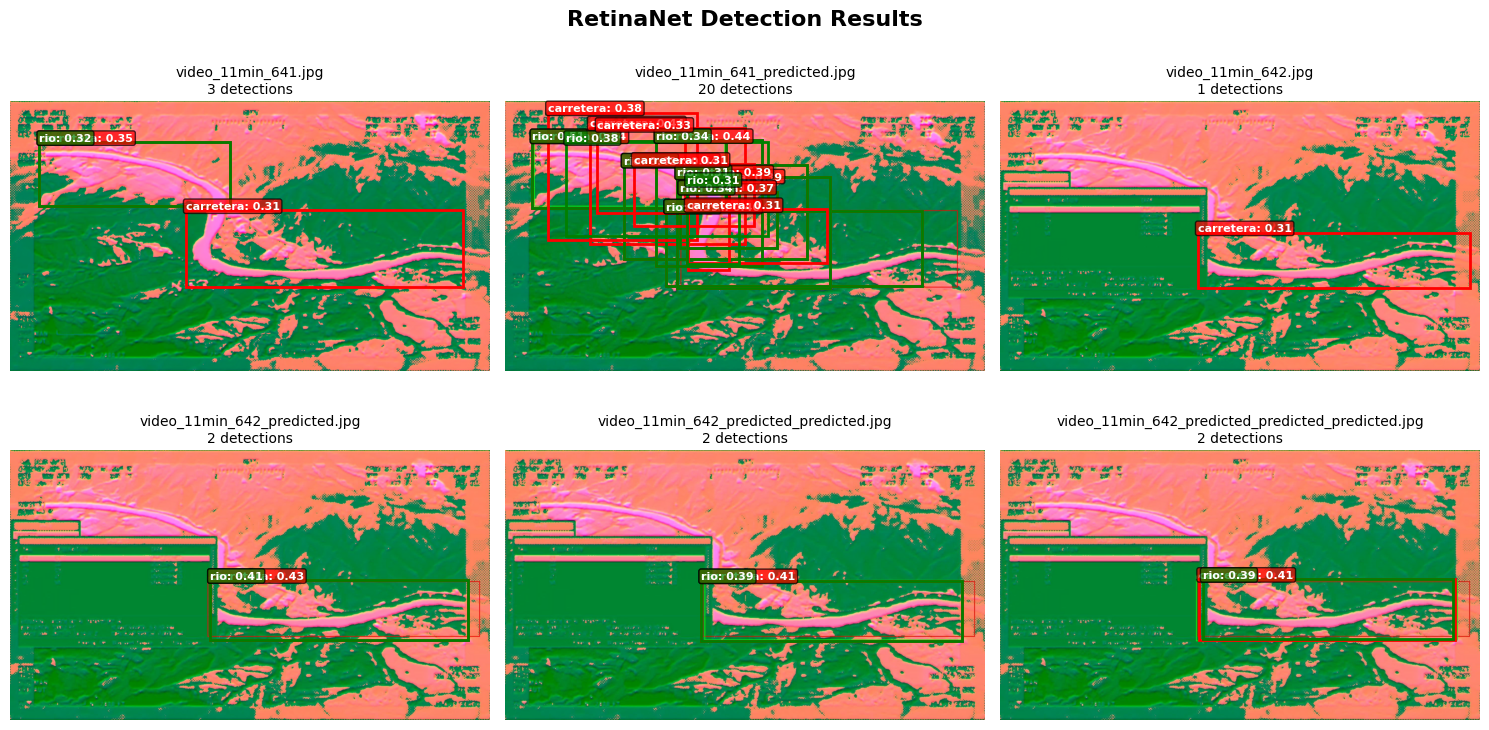


Available visualization functions:
- test_validation_images(confidence_threshold=0.3, show_plots=True)
- test_single_image('path/to/image.jpg', show_matplotlib=True)
- test_multiple_images('path/to/folder/', show_plots=True)
- show_image_grid(results)
- visualize_with_matplotlib(image, boxes, scores, labels, class_names)


In [ ]:
def test_multiple_images(images_dir, model_path='retinanet_best.pth', 
                        confidence_threshold=0.3, max_images=5, show_plots=True):
    """Test model on multiple images from a directory"""
    
    print(f"Testing RetinaNet on images from: {images_dir}")
    print("="*60)
    
    images_path = Path(images_dir)
    
    # Find image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_path.glob(ext)))
    
    if not image_files:
        print(f"No images found in {images_dir}")
        return
    
    print(f"Found {len(image_files)} images")
    
    # Load model once
    model, device = load_trained_retinanet(model_path)
    class_names = {0: 'carretera', 1: 'rio'}
    
    # Test on multiple images
    test_files = image_files[:max_images]
    results = []
    
    for i, image_file in enumerate(test_files):
        print(f"\n--- Image {i+1}/{len(test_files)}: {image_file.name} ---")
        
        try:
            # Make prediction
            image, boxes, scores, labels, original_size = predict_image(
                model, image_file, device, confidence_threshold
            )
            
            print(f"Size: {original_size}, Detections: {len(boxes)}")
            
            if len(boxes) > 0:
                # Draw and save predictions
                result_image = draw_predictions(image, boxes, scores, labels, class_names)
                
                # Save result
                output_path = image_file.parent / f"{image_file.stem}_predicted{image_file.suffix}"
                result_image.save(output_path)
                
                results.append({
                    'image_path': image_file,
                    'output_path': output_path,
                    'detections': len(boxes),
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels
                })
            else:
                print("  No detections found")
                
        except Exception as e:
            print(f"  Error processing {image_file.name}: {e}")
    
    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY - Processed {len(test_files)} images:")
    total_detections = sum(r['detections'] for r in results)
    print(f"  Total detections: {total_detections}")
    print(f"  Images with detections: {len(results)}")
    
    for class_id, class_name in class_names.items():
        class_count = sum(sum(1 for label in r['labels'] if label == class_id) for r in results)
        print(f"  {class_name}: {class_count} detections")
    
    # Show image grid if requested
    import torch
import torchvision
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Check for matplotlib availability
try:
    import matplotlib.pyplot as plt
    print("matplotlib is available")
except ImportError:
    import subprocess
    import sys
    print("Installing matplotlib...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt
    print("matplotlib installed and imported")

def load_trained_retinanet(model_path='retinanet_best.pth'):
    """Load the trained RetinaNet model"""
    print(f"Loading trained RetinaNet from: {model_path}")
    
    # Setup model architecture (same as training)
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    
    # Replace classification head for 2 classes
    num_classes = 2
    num_anchors = model.head.classification_head.num_anchors
    
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes
    )
    
    # Load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"Model loaded successfully on {device}")
    return model, device

def predict_image(model, image_path, device, confidence_threshold=0.3):
    """Make predictions on a single image"""
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Transform for model input
    transform = T.Compose([T.ToTensor()])
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        predictions = model(input_tensor)
    
    # Extract predictions
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    
    # Filter by confidence threshold
    mask = scores > confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return image, boxes, scores, labels, original_size

def draw_predictions(image, boxes, scores, labels, class_names, save_path=None):
    """Draw bounding boxes and labels on image"""
    
    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)
    
    # Define colors for each class
    colors = {
        0: (255, 0, 0),    # Red for carretera
        1: (0, 255, 0),    # Green for rio
    }
    
    # Try to load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()
    
    print(f"Drawing {len(boxes)} detections:")
    
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x1, y1, x2, y2 = box
        color = colors.get(label, (255, 255, 0))  # Default yellow
        
        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Prepare label text
        class_name = class_names.get(label, f"Class_{label}")
        label_text = f"{class_name}: {score:.2f}"
        
        # Draw label background
        text_bbox = draw.textbbox((x1, y1-25), label_text, font=font)
        draw.rectangle(text_bbox, fill=color)
        
        # Draw label text
        draw.text((x1, y1-25), label_text, fill=(255, 255, 255), font=font)
        
        print(f"  {i+1}. {class_name}: {score:.3f} at [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
    
    if save_path:
        draw_image.save(save_path)
        print(f"Result saved to: {save_path}")
    
    return draw_image

def visualize_with_matplotlib(image, boxes, scores, labels, class_names, title="RetinaNet Predictions"):
    """Visualize predictions using matplotlib"""
    
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    
    # Define colors for each class
    colors = {0: 'red', 1: 'green'}
    
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        color = colors.get(label, 'yellow')
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=3)
        plt.gca().add_patch(rect)
        
        # Add label
        class_name = class_names.get(label, f"Class_{label}")
        plt.text(x1, y1-10, f"{class_name}: {score:.2f}", 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                fontsize=12, color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def show_image_grid(results, max_images=6):
    """Show a grid of images with their predictions"""
    if not results:
        print("No results to display")
        return
    
    # Limit to max_images
    show_results = results[:max_images]
    
    # Calculate grid dimensions
    n_images = len(show_results)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle('RetinaNet Detection Results', fontsize=16, fontweight='bold')
    
    # Handle single image case
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    class_names = {0: 'carretera', 1: 'rio'}
    colors = {0: 'red', 1: 'green'}
    
    for i, result in enumerate(show_results):
        # Load and display image
        image = Image.open(result['image_path'])
        axes[i].imshow(image)
        axes[i].set_title(f"{result['image_path'].name}\n{result['detections']} detections", 
                         fontsize=10)
        axes[i].axis('off')
        
        # Draw bounding boxes
        for box, score, label in zip(result['boxes'], result['scores'], result['labels']):
            x1, y1, x2, y2 = box
            color = colors.get(label, 'yellow')
            
            # Draw rectangle
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, color=color, linewidth=2)
            axes[i].add_patch(rect)
            
            # Add label
            class_name = class_names.get(label, f"Class_{label}")
            axes[i].text(x1, y1-5, f"{class_name}: {score:.2f}", 
                        bbox=dict(boxstyle="round,pad=0.2", facecolor=color, alpha=0.7),
                        fontsize=8, color='white', fontweight='bold')
    
    # Hide empty subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



def test_single_image(image_path, model_path='retinanet_best.pth', confidence_threshold=0.3, 
                     save_result=True, show_matplotlib=True):
    """Test model on a single image"""
    
    print(f"Testing RetinaNet on: {image_path}")
    print("="*50)
    
    # Class mapping
    class_names = {0: 'carretera', 1: 'rio'}
    
    # Load model
    model, device = load_trained_retinanet(model_path)
    
    # Make prediction
    image, boxes, scores, labels, original_size = predict_image(
        model, image_path, device, confidence_threshold
    )
    
    print(f"Image size: {original_size}")
    print(f"Confidence threshold: {confidence_threshold}")
    print(f"Found {len(boxes)} detections")
    
    if len(boxes) > 0:
        # Draw predictions
        result_image = draw_predictions(image, boxes, scores, labels, class_names)
        
        # Save result
        if save_result:
            input_path = Path(image_path)
            output_path = input_path.parent / f"{input_path.stem}_predicted{input_path.suffix}"
            result_image.save(output_path)
            print(f"Result saved to: {output_path}")
        
        # Show with matplotlib
        if show_matplotlib:
            visualize_with_matplotlib(image, boxes, scores, labels, class_names, 
                                    title=f"RetinaNet Results - {Path(image_path).name}")
        
        # Show detection summary
        print(f"\nDetection Summary:")
        for class_id, class_name in class_names.items():
            count = sum(1 for label in labels if label == class_id)
            if count > 0:
                avg_conf = np.mean([score for score, label in zip(scores, labels) if label == class_id])
                print(f"  {class_name}: {count} detections (avg confidence: {avg_conf:.3f})")
        
        return result_image, boxes, scores, labels
    else:
        print("No detections found!")
        print("Try lowering the confidence threshold (e.g., 0.1 or 0.2)")
        
        if show_matplotlib:
            plt.figure(figsize=(10, 6))
            plt.imshow(image)
            plt.title(f"No Detections - {Path(image_path).name}", fontsize=14)
            plt.axis('off')
            plt.show()
        
        return image, boxes, scores, labels

def test_multiple_images(images_dir, model_path='retinanet_best.pth', 
                        confidence_threshold=0.3, max_images=5, show_plots=True):
    """Test model on multiple images from a directory"""
    
    print(f"Testing RetinaNet on images from: {images_dir}")
    print("="*60)
    
    images_path = Path(images_dir)
    
    # Find image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_path.glob(ext)))
    
    if not image_files:
        print(f"No images found in {images_dir}")
        return
    
    print(f"Found {len(image_files)} images")
    
    # Load model once
    model, device = load_trained_retinanet(model_path)
    class_names = {0: 'carretera', 1: 'rio'}
    
    # Test on multiple images
    test_files = image_files[:max_images]
    results = []
    
    for i, image_file in enumerate(test_files):
        print(f"\n--- Image {i+1}/{len(test_files)}: {image_file.name} ---")
        
        try:
            # Make prediction
            image, boxes, scores, labels, original_size = predict_image(
                model, image_file, device, confidence_threshold
            )
            
            print(f"Size: {original_size}, Detections: {len(boxes)}")
            
            if len(boxes) > 0:
                # Draw and save predictions
                result_image = draw_predictions(image, boxes, scores, labels, class_names)
                
                # Save result
                output_path = image_file.parent / f"{image_file.stem}_predicted{image_file.suffix}"
                result_image.save(output_path)
                
                results.append({
                    'image_path': image_file,
                    'output_path': output_path,
                    'detections': len(boxes),
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels
                })
            else:
                print("  No detections found")
                
        except Exception as e:
            print(f"  Error processing {image_file.name}: {e}")
    
    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY - Processed {len(test_files)} images:")
    total_detections = sum(r['detections'] for r in results)
    print(f"  Total detections: {total_detections}")
    print(f"  Images with detections: {len(results)}")
    
    for class_id, class_name in class_names.items():
        class_count = sum(sum(1 for label in r['labels'] if label == class_id) for r in results)
        print(f"  {class_name}: {class_count} detections")
    
    # Show image grid if requested
    if show_plots and results:
        print(f"\nGenerating visualization plots...")
        show_image_grid(results, max_images=min(6, len(results)))
    
    return results

# Example usage functions
def test_validation_images(model_path='retinanet_best.pth', confidence_threshold=0.3, show_plots=True):
    """Test on validation images"""
    val_images_dir = Path('data/ImagenesFiltradas/val/images')
    
    if val_images_dir.exists():
        print("Testing on validation images...")
        return test_multiple_images(val_images_dir, model_path, confidence_threshold, 
                                  max_images=10, show_plots=show_plots)
    else:
        print(f"Validation directory not found: {val_images_dir}")
        return None

def test_custom_image(image_path, confidence_threshold=0.3):
    """Test on a custom image"""
    if os.path.exists(image_path):
        return test_single_image(image_path, confidence_threshold=confidence_threshold)
    else:
        print(f"Image not found: {image_path}")
        return None

def display_image_in_console(image_path):
    """Display basic image info in console"""
    try:
        img = Image.open(image_path)
        print(f"Image Info: {img.size[0]}x{img.size[1]} pixels, Mode: {img.mode}")
        return True
    except Exception as e:
        print(f"Could not read image: {e}")
        return False

if __name__ == "__main__":
    print("RETINANET INFERENCE TESTING")
    print("="*50)
    
    # Test on validation images with plots
    print("1. Testing on validation images with visualizations:")
    val_results = test_validation_images(confidence_threshold=0.3, show_plots=True)
    
    # Example: Test on a specific image (replace with your image path)
    # print("\n2. Testing on custom image:")
    # custom_result = test_custom_image("path/to/your/test/image.jpg")
    
    print("\nAvailable visualization functions:")
    print("- test_validation_images(confidence_threshold=0.3, show_plots=True)")
    print("- test_single_image('path/to/image.jpg', show_matplotlib=True)")
    print("- test_multiple_images('path/to/folder/', show_plots=True)")
    print("- show_image_grid(results)")
    print("- visualize_with_matplotlib(image, boxes, scores, labels, class_names)")